In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load data into a DataFrame
df = pd.read_csv("./Resources/working_dataset.csv").set_index("time")
df.index = pd.to_datetime(df.index)
df.head()

,Symbol,PriceUSD,Percent of Change
time,,,
2010-07-18,btc,0.085840,0
2010-07-19,btc,0.080800,0
2010-07-20,btc,0.074736,0
2010-07-21,btc,0.079193,0
2010-07-22,btc,0.058470,0


In [3]:
dogecoin = df.loc[df["Symbol"] == "doge"]
dogecoin.head()

,Symbol,PriceUSD,Percent of Change
time,,,
2014-01-23,doge,0.001541,0
2014-01-24,doge,0.001888,0
2014-01-25,doge,0.001937,0
2014-01-26,doge,0.001937,0
2014-01-27,doge,0.001618,0


In [4]:
dogecoin.count()

Symbol               3325
PriceUSD             3325
Percent of Change    3325
dtype: int64

In [5]:
dogecoin_df = dogecoin.drop(["Symbol", "Percent of Change"], axis=1)
dogecoin_df

,PriceUSD
time,
2014-01-23,0.001541
2014-01-24,0.001888
2014-01-25,0.001937
2014-01-26,0.001937
2014-01-27,0.001618
...,...
2023-02-25,0.080644
2023-02-26,0.082143
2023-02-27,0.081280


In [6]:
def prepare_data(data, sequence_length):
    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Split data into training and testing sets
    training_data = scaled_data[:int(0.8*len(data)), :]
    testing_data = scaled_data[int(0.8*len(data)):, :]

    # Create sequences of data
    X_train, y_train = create_sequences(training_data, sequence_length)
    X_test, y_test = create_sequences(testing_data, sequence_length)

    return X_train, y_train, X_test, y_test, scaler


In [7]:
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data)-sequence_length-1):
        X.append(data[i:(i+sequence_length), :])
        y.append(data[i+sequence_length, 0])
    X = np.array(X)
    y = np.array(y)
    return X, y


In [8]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [9]:
# Prepare data
sequence_length = 30
X_train, y_train, X_test, y_test, scaler = prepare_data(dogecoin_df.values, sequence_length)

In [10]:
print(f' X (Training) Shape: {X_train.shape}')

 X (Training) Shape: (2629, 30, 1)


In [11]:
# Build model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

In [12]:
# Train/Fit LSTM model to training data
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
42/42 [==============================] - 158s 899ms/step - loss: 7.3845e-04 - val_loss: 0.0566
Epoch 2/50
42/42 [==============================] - 15s 353ms/step - loss: 3.6974e-04 - val_loss: 0.0043
Epoch 3/50
42/42 [==============================] - 21s 508ms/step - loss: 4.3718e-04 - val_loss: 0.0089
Epoch 4/50
42/42 [==============================] - 18s 431ms/step - loss: 3.1925e-04 - val_loss: 0.0107
Epoch 5/50
42/42 [==============================] - 16s 391ms/step - loss: 3.0632e-04 - val_loss: 0.0144
Epoch 6/50
42/42 [==============================] - 18s 422ms/step - loss: 2.9253e-04 - val_loss: 0.0027
Epoch 7/50
42/42 [==============================] - 15s 369ms/step - loss: 2.6821e-04 - val_loss: 0.0160
Epoch 8/50
42/42 [==============================] - 16s 393ms/step - loss: 2.6166e-04 - val_loss: 0.0146
Epoch 9/50
42/42 [==============================] - 17s 411ms/step - loss: 2.5769e-04 - val_loss: 0.0348
Epoch 10/50
42/42 [==============================] - 1

20/20 [==============================] - 9s 86ms/step


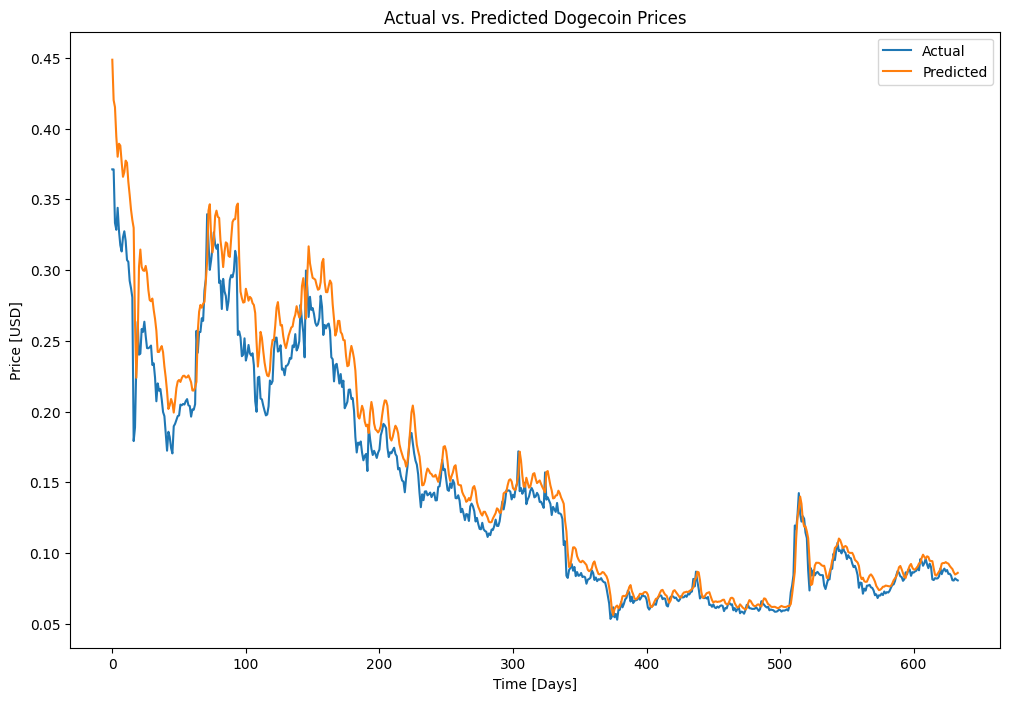

In [13]:
# Make predictions on testing data
predictions = model.predict(X_test)

# Denormalize predictions and actual values
y_pred_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(12, 8))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.xlabel('Time [Days]')
plt.ylabel('Price [USD]')
plt.title('Actual vs. Predicted Dogecoin Prices')
plt.legend()
plt.show()


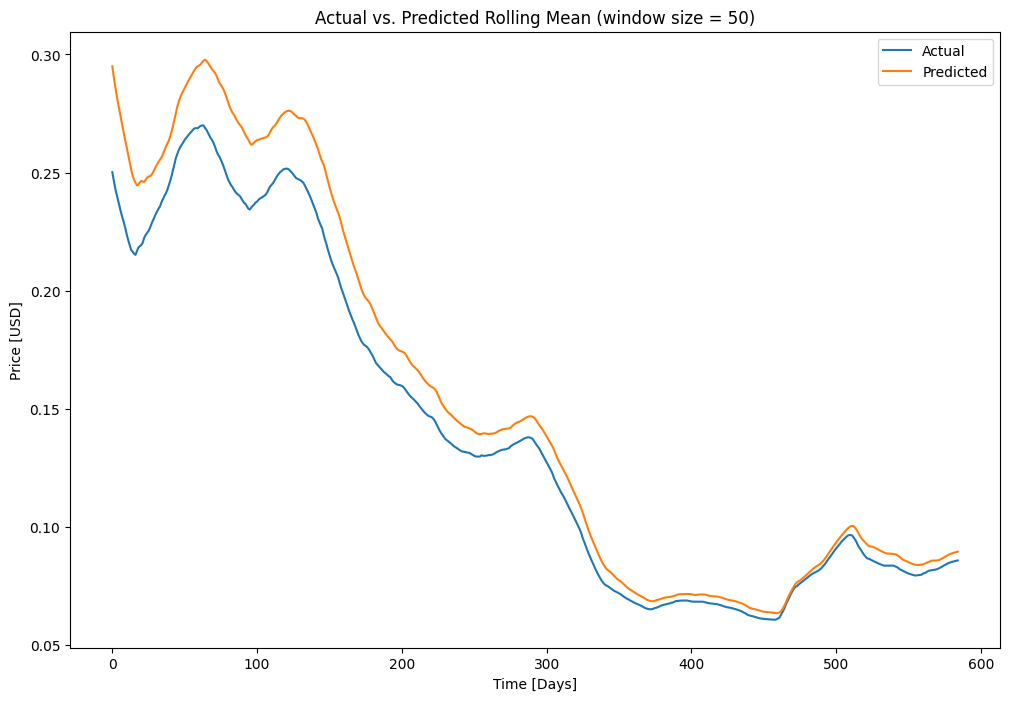

In [14]:
# Plot actual vs predicted prices with a rolling window
window_size = 50
rolling_y_test = pd.Series(y_test_inv.reshape(-1)).rolling(window_size).mean()[window_size-1:].values
rolling_y_pred = pd.Series(y_pred_inv.reshape(-1)).rolling(window_size).mean()[window_size-1:].values

plt.figure(figsize=(12, 8))
plt.plot(rolling_y_test, label='Actual')
plt.plot(rolling_y_pred, label='Predicted')
plt.title('Actual vs. Predicted Rolling Mean (window size = {})'.format(window_size))
plt.xlabel('Time [Days]')
plt.ylabel('Price [USD]')
plt.legend()
plt.show()


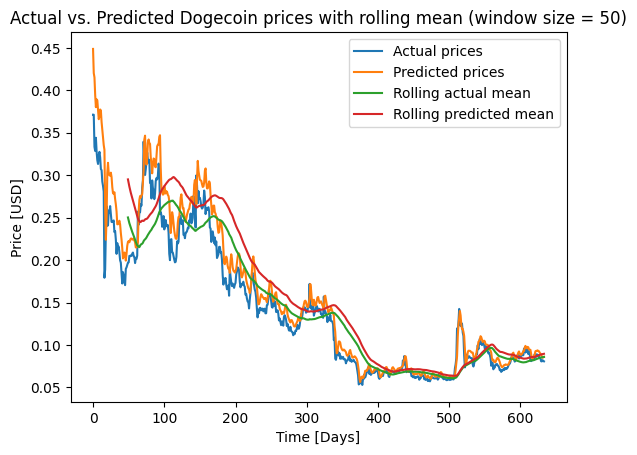

In [15]:
# Assume `y_test` is the actual Dogecoin prices and `predictions` is the predicted prices
# Convert them into pandas DataFrame for easier manipulation
y_test_df = pd.DataFrame(y_test_inv, columns=['actual'])
predictions_df = pd.DataFrame(y_pred_inv, columns=['predicted'])

# Concatenate the two DataFrames into one
results_df = pd.concat([y_test_df, predictions_df], axis=1)

# Set the window size for the rolling window
window_size = 50

# Calculate the rolling mean for both the actual and predicted prices
results_df['actual_mean'] = results_df['actual'].rolling(window_size).mean()
results_df['predicted_mean'] = results_df['predicted'].rolling(window_size).mean()

# Plot the actual and predicted prices with the rolling mean
plt.plot(results_df['actual'], label='Actual prices')
plt.plot(results_df['predicted'], label='Predicted prices')
plt.plot(results_df['actual_mean'], label='Rolling actual mean')
plt.plot(results_df['predicted_mean'], label='Rolling predicted mean')
plt.legend()
plt.title('Actual vs. Predicted Dogecoin prices with rolling mean (window size = {})'.format(window_size))
plt.xlabel('Time [Days]')
plt.ylabel('Price [USD]')
plt.show()


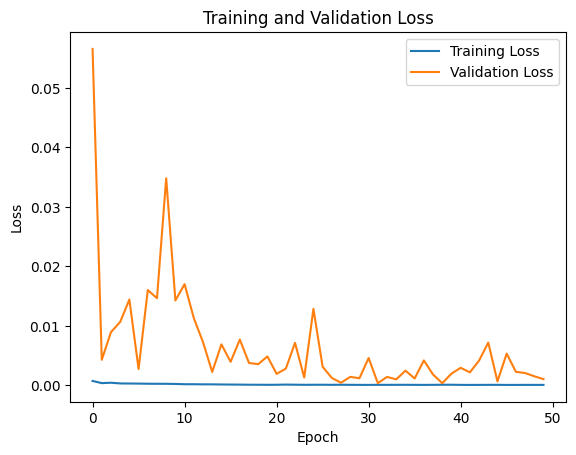

In [16]:
# Plot the training and validation loss over time/epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot a line chart of the training and validation MSE loss over the training epochs.

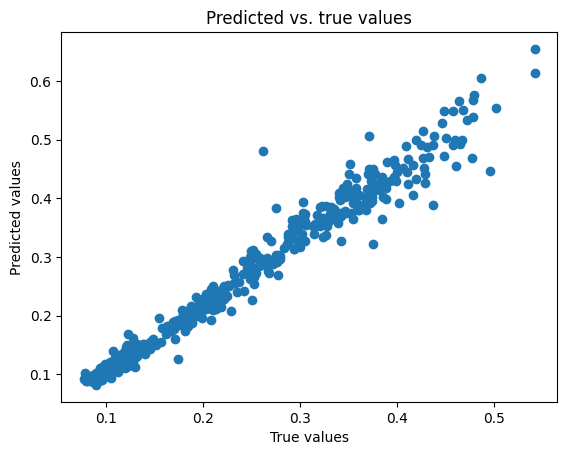

In [17]:
# Plot of the predicted values against the true values, which can help you visualize how well the model is able to predict the crypto prices.
plt.scatter(y_test, predictions)
plt.title('Predicted vs. true values')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.show()

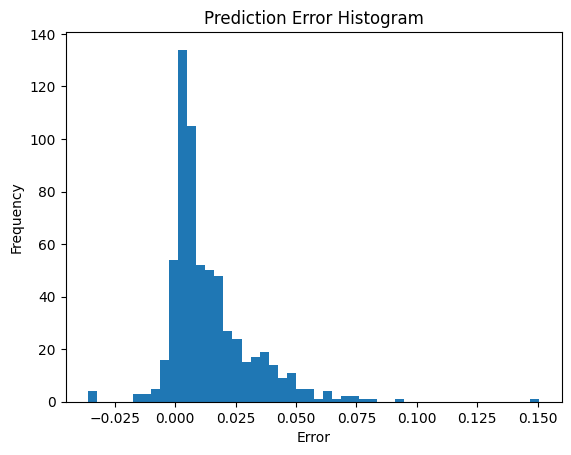

In [18]:
# Calculate prediction errors
errors = y_pred_inv - y_test_inv

# Plot histogram of errors
plt.hist(errors, bins=50)
plt.title('Prediction Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

In [19]:
# Calculate MSE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute mean absolute error
mae = mean_absolute_error(y_test, predictions)

# Compute coefficient of determination
r2 = r2_score(y_test, predictions)

# Compute mean squared error using evaluate method
mse_keras = model.evaluate(X_test, y_test)

# Calculate RMSE from MSE
rmse_keras = np.sqrt(mse_keras)

print('MSE (Keras):', mse_keras)
print('RMSE (Keras):', rmse_keras)
print('MAE:', mae)
print('R²:', r2)

20/20 [==============================] - 2s 85ms/step - loss: 0.0010
MSE (Keras): 0.0010475621093064547
RMSE (Keras): 0.032366064161501854
MAE: 0.022189247642284225
R²: 0.9174477974184718


In [20]:
# Save previous predictions
previous_predictions_df = predictions_df.copy()

# Get last n rows of dogecoin_df and set index of previous_predictions_df to match
n = len(previous_predictions_df)
previous_predictions_df.index = dogecoin_df.iloc[-n:].index

In [21]:
# Use the model to predict future prices
# First, get the last sequence of data from the training set
last_sequence = X_train[-1,:,:]
# Generate the future date range
future_dates = pd.date_range(start=dogecoin_df.index[-1], periods=60, freq='D')
# Create an empty array to hold the predicted prices
predicted_prices = np.zeros((60, 1))
# Iterate over the future date range
for i, date in enumerate(future_dates):
    # Predict the price for the next day using the last sequence of data
    predicted_price = model.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))
    # Add the predicted price to the array
    predicted_prices[i, 0] = predicted_price
    # Update the last sequence of data with the predicted price
    last_sequence = np.vstack((last_sequence[1:], predicted_price))

# Invert the scaling of the predicted prices
predicted_prices_inv = scaler.inverse_transform(predicted_prices)

# Create a dataframe with the predicted prices and the corresponding dates
predictions_df2 = pd.DataFrame(predicted_prices_inv, index=future_dates, columns=['predicted'])

1/1 [==============================] - 0s 219ms/step
            predicted
2023-03-01   0.439636
2023-03-02   0.455635
2023-03-03   0.463976
2023-03-04   0.470948
2023-03-05   0.479177
2023-03-06   0.490019
2023-03-07   0.504015
2023-03-08   0.521061
2023-03-09   0.540647
2023-03-10   0.562156
2023-03-11   0.584920
2023-03-12   0.608406
2023-03-13   0.632181
2023-03-14   0.655648
2023-03-15   0.679180
2023-03-16   0.702679
2023-03-17   0.726178
2023-03-18   0.750095
2023-03-19   0.774510
2023-03-20   0.799562
2023-03-21   0.825179
2023-03-22   0.851118
2023-03-23   0.877220
2023-03-24   0.903200
2023-03-25   0.928901
2023-03-26   0.954085
2023-03-27   0.978768
2023-03-28   1.002836
2023-03-29   1.026183
2023-03-30   1.048863
2023-03-31   1.070710
2023-04-01   1.091772
2023-04-02   1.112004
2023-04-03   1.131407
2023-04-04   1.149967
2023-04-05   1.167664
2023-04-06   1.184465
2023-04-07   1.200343
2023-04-08   1.215280
2023-04-09   1.229276
2023-04-10   1.242349
2023-04-11   1.254535
2

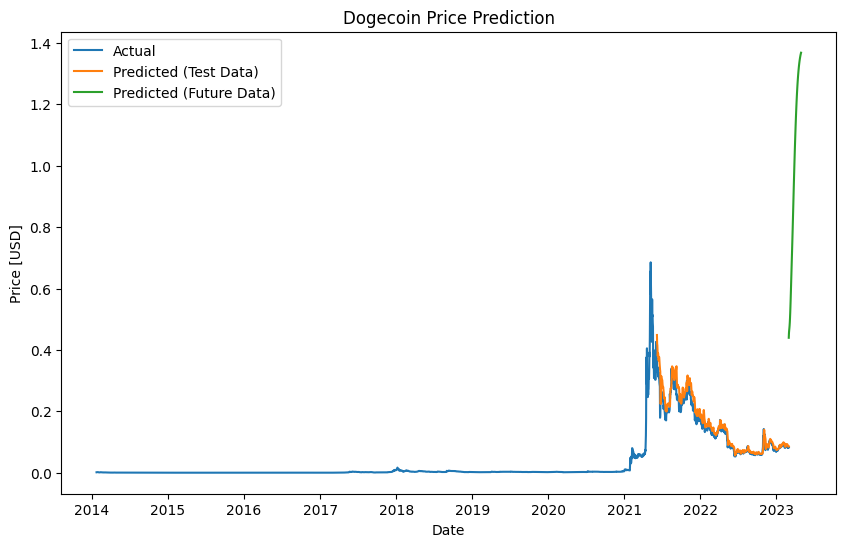

In [22]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(dogecoin_df.index, dogecoin_df.values, label='Actual')
plt.plot(previous_predictions_df.index, previous_predictions_df['predicted'], label='Predicted (Test Data)')
plt.plot(predictions_df2.index, predictions_df2['predicted'], label='Predicted (Future Data)')
plt.legend()
plt.title('Dogecoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price [USD]')
plt.show()

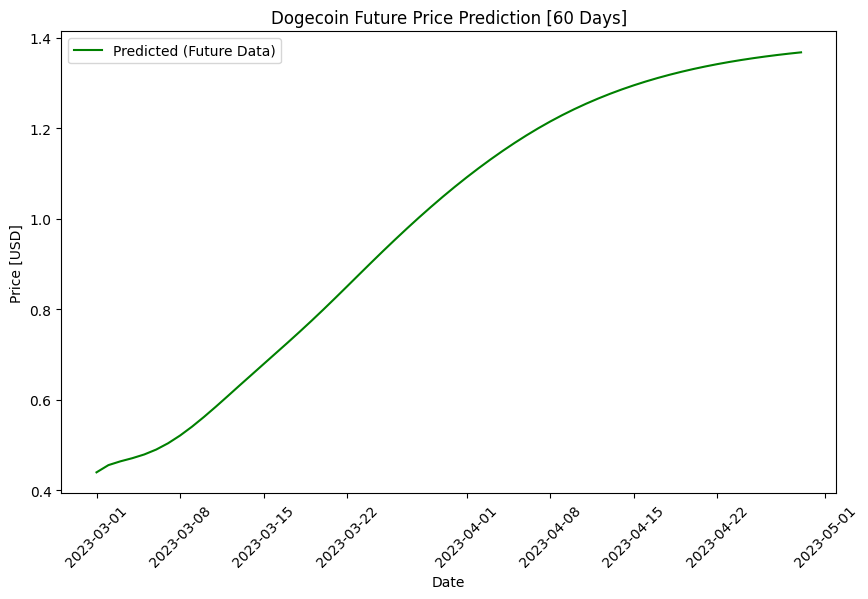

In [25]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(predictions_df2.index, predictions_df2['predicted'], color="green", label='Predicted (Future Data)')
plt.legend()
plt.title('Dogecoin Future Price Prediction [60 Days]')
plt.xlabel('Date')
plt.ylabel('Price [USD]')
plt.xticks(rotation=45)
plt.show()

In [23]:
previous_predictions_df

,predicted
time,
2021-06-06,0.448677
2021-06-07,0.420153
2021-06-08,0.415157
2021-06-09,0.394377
2021-06-10,0.380119
...,...
2023-02-25,0.088762
2023-02-26,0.086502
2023-02-27,0.084892


In [24]:
predictions_df2

,predicted
2023-03-01,0.439636
2023-03-02,0.455635
2023-03-03,0.463976
2023-03-04,0.470948
2023-03-05,0.479177
2023-03-06,0.490019
2023-03-07,0.504015
2023-03-08,0.521061
2023-03-09,0.540647
2023-03-10,0.562156
